In [1]:
import bayes3d as b
import os
import sys
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import flax.linen as nn
from flax.training import train_state
import flax
import optax
from tensorflow_probability.substrates import jax as tfp

In [3]:
import pickle
from typing import Any, Union

## CNN Inference

## 

In [4]:
NoneType = type(None)

In [5]:
class BaseCNN(nn.Module):
    range_min: Union[float, jnp.ndarray]
    range_max: Union[float, jnp.ndarray, NoneType]

    @nn.compact
    def __call__(self, imgs, train: bool): # XXX todo: make sure the sizes all line up
        x = nn.Conv(64, (10, 10), strides=(3, 3), padding='VALID')(imgs)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)
        x = nn.max_pool(x, (3, 3), strides=(2, 2))
        
        x = nn.Conv(256, (5, 5), strides=(2, 2), padding='VALID')(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)
        x = nn.max_pool(x, (2, 2), strides=(2, 2))
        
        x = nn.Dense(1024)(x.reshape(imgs.shape[0], -1))
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)
        
        #x = nn.Dense(1024)(x)
        #x = nn.BatchNorm(use_running_average=not train)(x)
        #x = nn.activation.leaky_relu(x)

        # x = nn.Dropout(rate=0.5, deterministic=not train)(x)
        
        # x = nn.Dense(1024)(x)
        # x = nn.BatchNorm(use_running_average=not train)(x)
        # x = nn.activation.leaky_relu(x)
        
        # x = nn.Dense(1024)(x)
        # x = nn.BatchNorm(use_running_average=not train)(x)
        # x = nn.activation.leaky_relu(x)
        
        # x = nn.Dropout(rate=0.5, deterministic=not train)(x)
        
        x = nn.Dense(576)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)
        
        # x = nn.Dropout(rate=0.5, deterministic=not train)(x)

        x = nn.Dense(192)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(24)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(1)(x)
        if self.range_max is not None:
            shift = (self.range_max + self.range_min) / 2
            scale = (self.range_max - self.range_min) / 2
            x = shift + scale * nn.soft_sign(x)
        else:
            x = nn.activation.relu(x)
        return x

In [6]:
class SceneModel(nn.Module):
    mean_model: nn.Module
    std_model: nn.Module

    @nn.compact
    def __call__(self, imgs, train: bool):
        means = self.mean_model(imgs, train)
        stds = self.std_model(imgs, train)
        return means, stds

In [7]:
cnn = SceneModel(mean_model=BaseCNN(0, 2*jnp.pi), std_model=BaseCNN(0, None))
params_key = jax.random.PRNGKey(0)
rngs = {'params': params_key} 
#cnn.tabulate(rngs, jnp.zeros((1, 100, 100, 1)), False, console_kwargs={'force_jupyter': True})

In [8]:
class TrainState(train_state.TrainState):
    batch_stats: Any

In [9]:
def create_train_state(module, key, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    #params_key, dropout_key = jax.random.split(key, 2)
    # initialize parameters by passing a template image
    variables = module.init(key,#, 'dropout': dropout_key},
                            jnp.ones([BATCH_SIZE, 100, 100, 1]), train=False)
    params, batch_stats = variables['params'], variables['batch_stats']
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx,
                             batch_stats=batch_stats)#, dropout_key=dropout_key)

In [10]:
normal_logpdf = jax.scipy.stats.norm.logpdf
truncnormal_logpdf = jax.scipy.stats.truncnorm.logpdf
beta_logpdf = jax.scipy.stats.beta.logpdf
vonmises = tfp.distributions.VonMises

In [11]:
@jax.jit
def train_step(state, img_batch, label_batch): 
    """Train for a single step."""
    def loss_fn(params):
        (means, stds), updates = state.apply_fn({'params': params, 'batch_stats': state.batch_stats},
                                                img_batch,
                                                train=True,
                                                mutable=['batch_stats'])
        #loss = -normal_logpdf(label_batch, loc=means, scale=stds).sum()
        loss = -vonmises(loc=means, concentration=stds).log_prob(label_batch).sum()
        #loss = jnp.sum((means - label_batch)**2)
        return loss, updates
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=updates['batch_stats'])
    return state, loss

In [12]:
train_data_file = jnp.load('train_data_noxy_1e2.npz')
test_data_file = jnp.load('test_data_noxy.npz')

In [13]:
train_imgs = train_data_file['arr_0']
train_labels = train_data_file['arr_1']

In [14]:
train_imgs.shape, train_labels.shape

((100, 100, 100, 1), (100, 1))

In [15]:
test_imgs = test_data_file['arr_0']
test_labels = test_data_file['arr_1']

In [16]:
test_imgs.shape, test_labels.shape

((2000, 100, 100, 1), (2000, 1))

In [17]:
N_TRAIN = train_imgs.shape[0]
N_TEST = test_imgs.shape[0]
N_EPOCHS = 50
BATCH_SIZE = 10 #20
LEARNING_RATE = 1e-6 #1e-8
MOMENTUM = 0.9
assert N_TRAIN % BATCH_SIZE == 0
assert N_TEST % BATCH_SIZE == 0

In [18]:
state = create_train_state(cnn, jax.random.PRNGKey(0), LEARNING_RATE, MOMENTUM)

In [19]:
shuffling_key = jax.random.PRNGKey(1)

In [20]:
training_losses = []

In [21]:
for epoch in range(N_EPOCHS):
    training_losses.append([])
    perm = jax.random.permutation(shuffling_key, N_TRAIN)
    train_imgs = train_imgs[perm]
    train_labels = train_labels[perm]
    shuffling_key = jax.random.split(shuffling_key, 2)[1]

    for step in tqdm(range(N_TRAIN // BATCH_SIZE)):
        img_batch = train_imgs[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        label_batch = train_labels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        
        state, loss = train_step(state, img_batch, label_batch)
        training_losses[-1].append(loss)
        #print(loss)
        #os.system('nvidia-smi')

    epoch_loss = jnp.array(training_losses[-1]).mean()
    #epoch_train_loss = calc_avg_loss_batched(state, train_imgs, train_labels)
    #epoch_test_loss = calc_avg_loss_batched(state, test_imgs, test_labels)
    epoch_train_loss = 'not calculated'
    epoch_test_loss = 'not calculated'
    print(f'epoch: {epoch}, average loss: {epoch_loss}, '
          f'train loss: {epoch_train_loss}, '
          f'test loss: {epoch_test_loss}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.47it/s]


epoch: 0, average loss: 19.223941802978516, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 470.63it/s]


epoch: 1, average loss: 18.688016891479492, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 512.45it/s]


epoch: 2, average loss: 18.125211715698242, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 504.07it/s]


epoch: 3, average loss: 17.82227897644043, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 485.19it/s]


epoch: 4, average loss: 17.63236427307129, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 477.93it/s]


epoch: 5, average loss: 17.53891372680664, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 534.38it/s]


epoch: 6, average loss: 16.983413696289062, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 473.25it/s]


epoch: 7, average loss: 17.082300186157227, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 516.63it/s]


epoch: 8, average loss: 16.74196434020996, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 507.15it/s]


epoch: 9, average loss: 16.69577407836914, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 502.38it/s]


epoch: 10, average loss: 16.619293212890625, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 434.44it/s]


epoch: 11, average loss: 16.593769073486328, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 458.60it/s]


epoch: 12, average loss: 16.072044372558594, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 495.50it/s]


epoch: 13, average loss: 16.205522537231445, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 491.91it/s]


epoch: 14, average loss: 15.88489818572998, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 499.94it/s]


epoch: 15, average loss: 15.908332824707031, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 520.70it/s]


epoch: 16, average loss: 16.39771270751953, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 528.71it/s]


epoch: 17, average loss: 15.991426467895508, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 520.73it/s]


epoch: 18, average loss: 15.489625930786133, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 497.07it/s]


epoch: 19, average loss: 15.955708503723145, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 515.14it/s]


epoch: 20, average loss: 15.661784172058105, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 504.88it/s]


epoch: 21, average loss: 15.335677146911621, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 488.10it/s]


epoch: 22, average loss: 15.79033088684082, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 481.85it/s]


epoch: 23, average loss: 15.586740493774414, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 495.45it/s]


epoch: 24, average loss: 15.304039001464844, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 479.17it/s]


epoch: 25, average loss: 15.422487258911133, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 478.34it/s]


epoch: 26, average loss: 15.516364097595215, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 476.72it/s]


epoch: 27, average loss: 15.1580810546875, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 488.69it/s]


epoch: 28, average loss: 15.129229545593262, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 516.74it/s]


epoch: 29, average loss: 14.989392280578613, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 496.48it/s]


epoch: 30, average loss: 15.095091819763184, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 517.45it/s]


epoch: 31, average loss: 15.574274063110352, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 499.20it/s]


epoch: 32, average loss: 15.206068992614746, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 464.94it/s]


epoch: 33, average loss: 15.048579216003418, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 497.86it/s]


epoch: 34, average loss: 14.611632347106934, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 483.91it/s]


epoch: 35, average loss: 15.048372268676758, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 516.82it/s]


epoch: 36, average loss: 14.623598098754883, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 499.57it/s]


epoch: 37, average loss: 14.614822387695312, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 496.70it/s]


epoch: 38, average loss: 14.561963081359863, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 510.91it/s]


epoch: 39, average loss: 14.588343620300293, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 475.57it/s]


epoch: 40, average loss: 14.907727241516113, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 505.08it/s]


epoch: 41, average loss: 14.501851081848145, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 512.79it/s]


epoch: 42, average loss: 14.408782005310059, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 492.92it/s]


epoch: 43, average loss: 15.104353904724121, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 503.83it/s]


epoch: 44, average loss: 14.53726863861084, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 491.76it/s]


epoch: 45, average loss: 15.150238037109375, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 516.97it/s]


epoch: 46, average loss: 14.15197467803955, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 511.29it/s]


epoch: 47, average loss: 14.486063957214355, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 509.13it/s]


epoch: 48, average loss: 14.325119018554688, train loss: not calculated, test loss: not calculated


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 531.36it/s]

epoch: 49, average loss: 14.271240234375, train loss: not calculated, test loss: not calculated


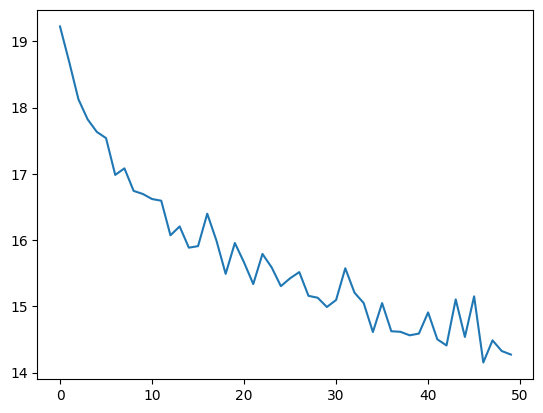

In [22]:
plt.plot([jnp.array(l).mean() for l in training_losses])

In [23]:
with open('param_file_noxy_1e2.pkl', 'wb') as params_file:
     pickle.dump(state.params, params_file)

In [24]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
b.RENDERER.add_mesh_from_file(model_dir + '/obj_000014.ply', scaling_factor=1e-3)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [25]:
def get_poses_non_jit(contact_params, id_table, id):
    sg = b.scene_graph.SceneGraph(
        root_poses=jnp.array([table_pose, jnp.eye(4)]),
        box_dimensions=jnp.array([b.RENDERER.model_box_dims[id_table], b.RENDERER.model_box_dims[id]]),
        parents=jnp.array([-1, 0]),
        contact_params=jnp.array([jnp.zeros(3), contact_params]),
        face_parent=jnp.array([-1,2]),
        face_child=jnp.array([-1,3]),
    )
    poses = sg.get_poses()
    return poses
get_poses = jax.jit(get_poses_non_jit)

def render_image_non_jit(dx, dy, theta):
    id_table = 1
    id = 0
    poses = get_poses_non_jit(jnp.array([dx, dy, theta]), id_table, id)
    img = b.RENDERER.render(
        poses , jnp.array([id_table, id])
    )[...,:3]
    return img
    
render_image = jax.jit(render_image_non_jit)

In [26]:
i = 0
b.viz.scale_image(b.get_depth_image(train_imgs[i, :, :, 0]), 2)
train_labels[i]

array([0.9267334], dtype=float32)

In [27]:
means, _ = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                        train_imgs[i, :, :, 0].reshape((1, 100, 100, 1)), train=False, mutable=False)
means

Array([[1.0945456]], dtype=float32)

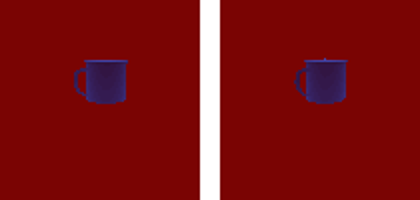

In [28]:
b.viz.scale_image(b.viz.hstack_images([b.get_depth_image(render_image(0, 0, means.flatten()[0])[:, :, 2]),
                                       b.get_depth_image(train_imgs[i, :, :, 0])]), 2)

In [29]:
def prediction_img(i):
    means, stds = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                               test_imgs[i, :, :, 0].reshape((1, 100, 100, 1)), train=False, mutable=False)
    return b.get_depth_image(render_image(0, 0, means.flatten()[0])[:, :, 2]), means, stds

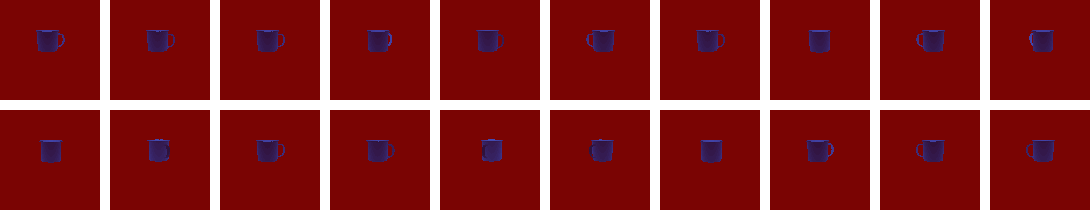

In [30]:
idxs = jax.random.randint(jax.random.PRNGKey(3141), (10,), 0, N_TEST)
imgs, means,stds = zip(*[prediction_img(i) for i in idxs])
gt_imgs = [b.get_depth_image(test_imgs[i, :, :, 0]) for i in idxs]
b.viz.vstack_images([b.viz.hstack_images(imgs),
                     b.viz.hstack_images(gt_imgs)])

In [31]:
means

(Array([[4.4975142]], dtype=float32),
 Array([[4.807955]], dtype=float32),
 Array([[4.618105]], dtype=float32),
 Array([[4.0275455]], dtype=float32),
 Array([[5.089918]], dtype=float32),
 Array([[1.7103276]], dtype=float32),
 Array([[4.834152]], dtype=float32),
 Array([[3.41342]], dtype=float32),
 Array([[1.7467306]], dtype=float32),
 Array([[2.2240374]], dtype=float32))

In [32]:
stds

(Array([[0.]], dtype=float32),
 Array([[0.]], dtype=float32),
 Array([[0.23520239]], dtype=float32),
 Array([[0.]], dtype=float32),
 Array([[0.]], dtype=float32),
 Array([[0.]], dtype=float32),
 Array([[0.]], dtype=float32),
 Array([[0.]], dtype=float32),
 Array([[0.7793547]], dtype=float32),
 Array([[1.0099144]], dtype=float32))

In [33]:
means, stds = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats},
                             test_imgs, train=False, mutable=False)
-vonmises(loc=means, concentration=stds).log_prob(test_labels).sum()

Array(3109.2837, dtype=float32)